# Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import collections
from lmfit import Minimizer, Parameters, report_fit
from lmfit.lineshapes import gaussian, lorentzian, split_lorentzian
from scipy import integrate
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('df_t90_repeat.csv')
# Use read_csv function to read .csv file.

df.rename(columns={'Unnamed: 0': 'Original Index'}, inplace=True)
# Rename the column label of the 0th column in place.
df

Original Index Condition  99.051832  103.563047  108.072082  112.576815  \
0                56     C1_R1     5652.0      6287.0      6609.0      6198.0   
1                57     C1_R1     5794.0      6237.0      6446.0      6108.0   
2                58     C1_R1     5706.0      6378.0      6434.0      6184.0   
3                59     C1_R1     5780.0      6258.0      6295.0      6200.0   
4                60     C1_R1     5772.0      6323.0      6501.0      6145.0   
..              ...       ...        ...         ...         ...         ...   
130             844    C10_R3     5260.0      5857.0      6093.0      5844.0   
131             845    C10_R3     5133.0      5776.0      5999.0      5702.0   
132             846    C10_R3     5367.0      5914.0      5920.0      5618.0   
133             847    C10_R3     5288.0      5765.0      5891.0      5676.0   
134             848    C10_R3     5289.0      5911.0      6119.0      5743.0   

     117.079374  121.579759  126.075853  130.567658  ...  2472.877365  \
0        5625.0      5204.0      4524.0      4190.0  ...        181.0   
1        5468.0      4953.0      4518.0      4199.0  ...        230.0   
2        5662.0      4950.0      4595.0      4069.0  ...        105.0   
3        5488.0      4996.0      4597.0      4145.0  ...        194.0   
4        5457.0      5000.0      4480.0      4154.0  ...        169.0   
..          ...         ...         ...         ...  ...          ...   
130      5380.0      4895.0      4416.0      4121.0  ...        153.0   
131      5302.0      4909.0      4466.0      4119.0  ...         89.0   
132      5185.0      4933.0      4438.0      4137.0  ...        140.0   
133      5371.0      4751.0      4592.0      4038.0  ...        130.0   
134      5308.0      4786.0      4466.0      4099.0  ...        107.0   

     2476.040621  2479.201030  2482.361832  2485.521408  2488.678140  \
0          120.0        131.0        145.0        115.0        218.0   
1          110.0        126.0        206.0        102.0        179.0   
2          142.0        144.0        170.0        142.0        187.0   
3          146.0        131.0        227.0        118.0        202.0   
4          119.0        134.0        210.0         86.0        140.0   
..           ...          ...          ...          ...          ...   
130        113.0         91.0        110.0         42.0        165.0   
131         59.0         95.0        129.0         53.0        151.0   
132        118.0         51.0        173.0         57.0        135.0   
133         64.0         47.0        123.0         53.0        137.0   
134         37.0        120.0        158.0         56.0        145.0   

     2491.835266  2494.989551  2498.139382  2501.291225  
0          261.0        120.0        150.0        147.0  
1          221.0        121.0        179.0        137.0  
2          197.0        178.0        167.0        128.0  
3          182.0        118.0        167.0        182.0  
4          195.0         98.0        158.0        148.0  
..           ...          ...          ...          ...  
130        173.0        143.0        104.0         77.0  
131        125.0        146.0         84.0         91.0  
132        136.0        108.0        111.0         98.0  
133        177.0         79.0        120.0        134.0  
134        120.0        105.0         78.0        117.0  

[135 rows x 639 columns]

# Test Plots and Baseline Correction

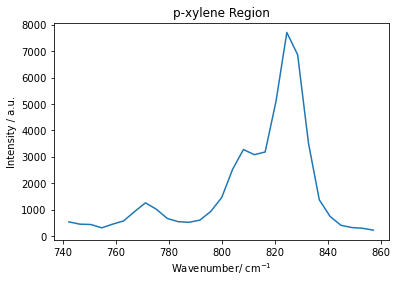

In [3]:
# Extract relevant p-xylene region and Vinyl region from the 1st spectra for
# baseline correction and plot tests.

pxyl_Region = df.iloc[0, 151:180] # Extract 1st spectra at the pxyl region and plot.
pxyl_Region.index = pxyl_Region.index.astype(float) # Change the index type to float.
pxyl_Region.plot()
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region')
plt.show()

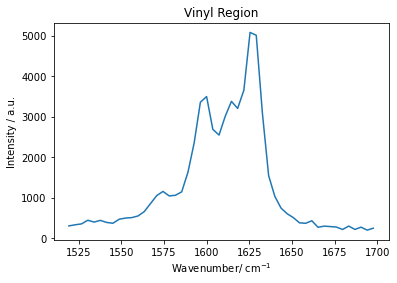

In [4]:
Vinyl_Region = df.iloc[0, 350:400] # Extract 1st spectra at the Vinyl region and plot.
Vinyl_Region.index = Vinyl_Region.index.astype(float) # Change the index type to float.
Vinyl_Region.plot()
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region')
plt.show()

# Baseline Subtraction

## Custom

Choose two regions on the spectrum that you want to form the basis for the baseline. The spectrum is based on the truncated region of interest from the raw spectrum.

Choose from the curve above, <10 and >50 to form the x and y values to fit a polynomial line, serving as my baseline values. **Note that the x-axis is the placeholder index location of the truncated spectra, not the actual wavenumbers themselves**

p-xylene Region Baseline Subtraction

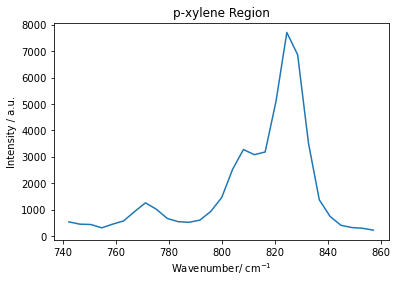

In [5]:
# p-xylene Region Baseline Subtraction
y = df.iloc[0, 151:180]
y.index = y.index.astype('float')
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region')
y.plot()
plt.show()

# y is a Series. A pandas Series is a lablled/ indexed 1-D array. Therefore, a single argument of y,
# itself containing the intensity value (y-axis) at the corresponding wavenumber (x-axis) can be plotted. 

# Plot the 1st spectra (1st row) of df_t0.

In [6]:
xbl = [] # x-baseline.

for items in y.index[:5].values.tolist():
    xbl.append(items)

for items in y.index[25:].values.tolist():
    xbl.append(items)

# Recall that y is a Series with intensities labelled by their wavenumbers. y.index gives the Series labels, which are the 
# wavenumbers. y.index[:10] gives the 0th to 9th Series labels and is an index object. Convert the index object to a numpy
# array via y.index[:10].values, then put them into a list via y.index[:10].values.tolist().

# There are 2 for loops for the xbl (x baseline) list because you want the 1st 10 wavenumbers, but you also want the last
# wavenumbers from index 40 onwards. In the end, xbl is a single list containing all wavenumbers from index 0 to 9,
# and then from index 40 onwards. The same ideas apply for ybl, except for the fact that ybl contains intensities.

ybl = [] # y-baseline.

for items in y.values[:5].tolist():
    ybl.append(items)

for items in y.values[25:].tolist():
    ybl.append(items)
    
# y is a Pandas Series. Therefore, y.values immediately gives the values witihn that series, which are the intensities.

In [7]:
# Check that the range of xbl and ybl values makes sense.
xbl_and_ybl = list(zip(xbl, ybl))# Zip xbl and ybl together, then use list function to unpack the zipped object.
xbl_and_ybl

[(742.41965, 532.0),
 (746.548026, 445.0),
 (750.676492, 433.0),
 (754.803068, 307.0),
 (758.925774, 446.0),
 (844.962895, 403.0),
 (849.032682, 318.0),
 (853.10062, 290.0),
 (857.166712, 220.0)]

Running the baseline fit. **(x-values, y-values, polynomial degree)** are the arguments.

In [8]:
blpars = np.polyfit(xbl, ybl, 1)
# blpars contains the baseline parameters; the coefficients which will allow for the baseline polynomial to be defined.
# Fit a polynomial based on the x and y-values chosen for the spectra during the previous step. Thus, given a list of x values
# and its corresponding y-values, fit a polynomial through these points as best as you can. This polynomial will serve as the 
# baseline to be subtracted from the spectra's y-values. 
# numpy.polyfit(x, y, deg)
# np.polyfit: Least squares polynomial fit. Fit a polynomial p(x) = p[0] * x**deg + ... + p[deg] of degree deg to points (x, y).
# Returns a vector of coefficients p that minimises the squared error in the order deg, deg-1, … 0.
# Since degree = 1, we are fitting a straight line.

blfit = np.poly1d(blpars)
# A one-dimensional polynomial class. A convenience class, used to encapsulate “natural” operations on polynomials so that
# said operations may take on their customary form in code. blfit is a function that encompasses information on blpar's vector
# of coefficients derived from the np.polyfit step. It will take an input of x-values, then apply the coefficients to the
# x-values to obtain the best fit polynomial following the p(x) equation defined above.

Plot showing before and after subtraction.

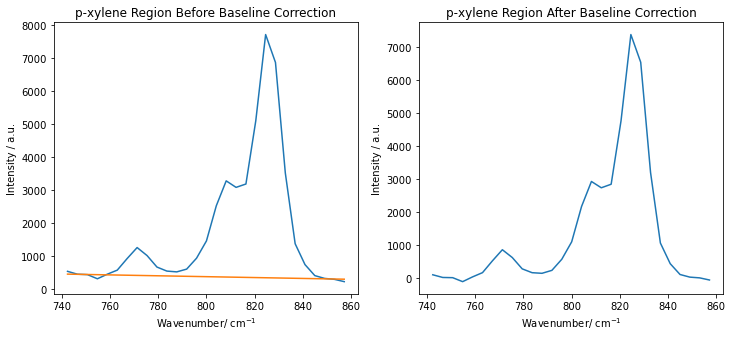

In [9]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1) # subplot(nrows, ncols, index)
plt.plot(y) # Plot the spectrum using the Series y.
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region Before Baseline Correction')
plt.plot(y.index, blfit(y.index))
# Plot the baseline polynomial to be subtracted (orange color). The x-axis will contain the wavenumbers. 
# Therefore y.index(Series labels) is being plotted at the x-axis. The y-axis will be blfit(y.index) because the output of 
# blfit(y.index) contains the y-values of the polynomial that is best fit to the input x-values.

plt.subplot(1,2,2)
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region After Baseline Correction')
plt.plot(y.index,(y - blfit(y.index)))
# Plot the baseline corrected spectrum. Subtraction can immediately be done because blfit(y.index) is a numpy array of y-values
# of the best fit polynomial. So the each value in Series y will minus each value in array blfit(y.index),
# to yield a final y value, which is the corrected spectra intensity. 

plt.show()

Vinyl Region Baseline Subtraction

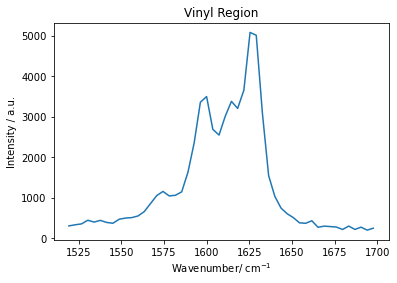

In [10]:
# Vinyl Region Baseline Subtraction
y = df.iloc[0, 350:400]
y.index = y.index.astype('float')
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region')
y.plot()
plt.show()

In [11]:
xbl = []

for items in y.index[:10].values.tolist():
    xbl.append(items)

for items in y.index[40:].values.tolist():
    xbl.append(items)
    
ybl = []

for items in y.values[:10].tolist():
    ybl.append(items)

for items in y.values[40:].tolist():
    ybl.append(items)

In [12]:
xbl_and_ybl = list(zip(xbl, ybl))
xbl_and_ybl

[(1519.340381, 297.0),
 (1523.028025, 325.0),
 (1526.712278, 347.0),
 (1530.394958, 437.0),
 (1534.076064, 392.0),
 (1537.753787, 434.0),
 (1541.431751, 383.0),
 (1545.106336, 363.0),
 (1548.777543, 462.0),
 (1552.448994, 491.0),
 (1665.214041, 264.0),
 (1668.819953, 291.0),
 (1672.42256, 281.0),
 (1676.025433, 268.0),
 (1679.623223, 209.0),
 (1683.221281, 293.0),
 (1686.816043, 210.0),
 (1690.409292, 266.0),
 (1694.00103, 193.0),
 (1697.591258, 240.0)]

In [13]:
blpars = np.polyfit(xbl, ybl, 1)
blfit = np.poly1d(blpars)

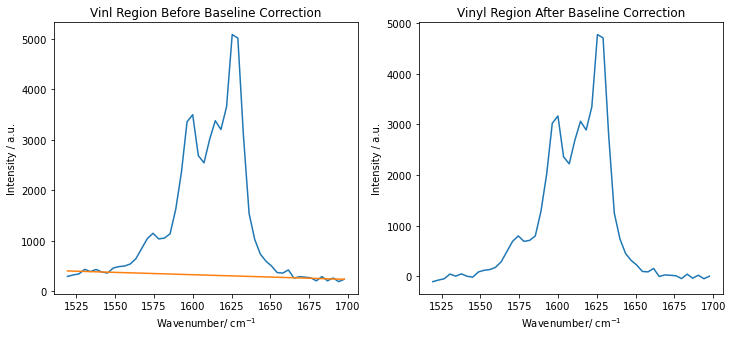

In [14]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
plt.plot(y)
plt.plot(y.index, blfit(y.index))
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinl Region Before Baseline Correction')

plt.subplot(1,2,2)
plt.plot(y.index,(y - blfit(y.index))) 
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region After Baseline Correction')

plt.show()

# Fitting Functions

In [15]:
from lmfit import Minimizer, Parameters, report_fit
from lmfit.lineshapes import gaussian, lorentzian, split_lorentzian

def residuals(pars,x,y):
    
    model =  (lorentzian(x, pars['ampL1'], pars['cenL1'], pars['widL1']) +
              lorentzian(x, pars['ampL2'], pars['cenL2'], pars['widL2']))
    
    return model - y

# Running Curve Fits

In [16]:
df_vinyl = df.iloc[:, 350:400].copy()
df_vinyl.columns = df_vinyl.columns.astype('float')
df_vinyl

1519.340381  1523.028025  1526.712278  1530.394958  1534.076064  \
0          297.0        325.0        347.0        437.0        392.0   
1          313.0        360.0        379.0        362.0        396.0   
2          335.0        339.0        348.0        362.0        311.0   
3          347.0        303.0        332.0        345.0        404.0   
4          296.0        342.0        401.0        393.0        345.0   
..           ...          ...          ...          ...          ...   
130        224.0        230.0        284.0        351.0        311.0   
131        231.0        242.0        277.0        323.0        309.0   
132        199.0        245.0        284.0        335.0        351.0   
133        189.0        261.0        256.0        373.0        267.0   
134        242.0        228.0        296.0        315.0        322.0   

     1537.753787  1541.431751  1545.106336  1548.777543  1552.448994  ...  \
0          434.0        383.0        363.0        462.0        491.0  ...   
1          396.0        408.0        469.0        479.0        426.0  ...   
2          422.0        390.0        460.0        446.0        488.0  ...   
3          369.0        358.0        401.0        463.0        489.0  ...   
4          353.0        358.0        408.0        426.0        476.0  ...   
..           ...          ...          ...          ...          ...  ...   
130        377.0        343.0        361.0        464.0        490.0  ...   
131        313.0        377.0        368.0        410.0        488.0  ...   
132        314.0        379.0        387.0        451.0        484.0  ...   
133        365.0        392.0        457.0        392.0        532.0  ...   
134        360.0        343.0        431.0        415.0        466.0  ...   

     1665.214041  1668.819953  1672.422560  1676.025433  1679.623223  \
0          264.0        291.0        281.0        268.0        209.0   
1          300.0        282.0        221.0        280.0        195.0   
2          260.0        343.0        263.0        251.0        223.0   
3          336.0        333.0        248.0        239.0        283.0   
4          232.0        332.0        269.0        252.0        208.0   
..           ...          ...          ...          ...          ...   
130        279.0        330.0        250.0        278.0        214.0   
131        316.0        311.0        275.0        254.0        228.0   
132        274.0        287.0        198.0        218.0        207.0   
133        280.0        363.0        283.0        300.0        157.0   
134        298.0        302.0        241.0        207.0        168.0   

     1683.221281  1686.816043  1690.409292  1694.001030  1697.591258  
0          293.0        210.0        266.0        193.0        240.0  
1          222.0        243.0        264.0        192.0        195.0  
2          244.0        192.0        248.0        202.0        232.0  
3          235.0        227.0        251.0        200.0        183.0  
4          249.0        229.0        246.0        231.0        211.0  
..           ...          ...          ...          ...          ...  
130        282.0        169.0        188.0        129.0        178.0  
131        192.0        154.0        213.0        189.0        134.0  
132        242.0        266.0        196.0        192.0        160.0  
133        271.0        249.0        232.0        127.0        147.0  
134        238.0        196.0        210.0        168.0        165.0  

[135 rows x 50 columns]

For 2 Lorentzians peak fits within the region of interest:

## Select initial guess parameters, namely amplitude, centre, width of the peaks.

In [17]:
ampL1 = 160000 # Peak Amplitude of 1st Peak
cenL1 = 1599 # Peak location of 1st Peak
widL1 = 8

ampL2 = 200000 # Peak Amplitude of 2nd Peak
cenL2 = 1627 # Peak location of 2nd Peak
widL2 = 6

## Fitting and Plotting (Vinyl Region)

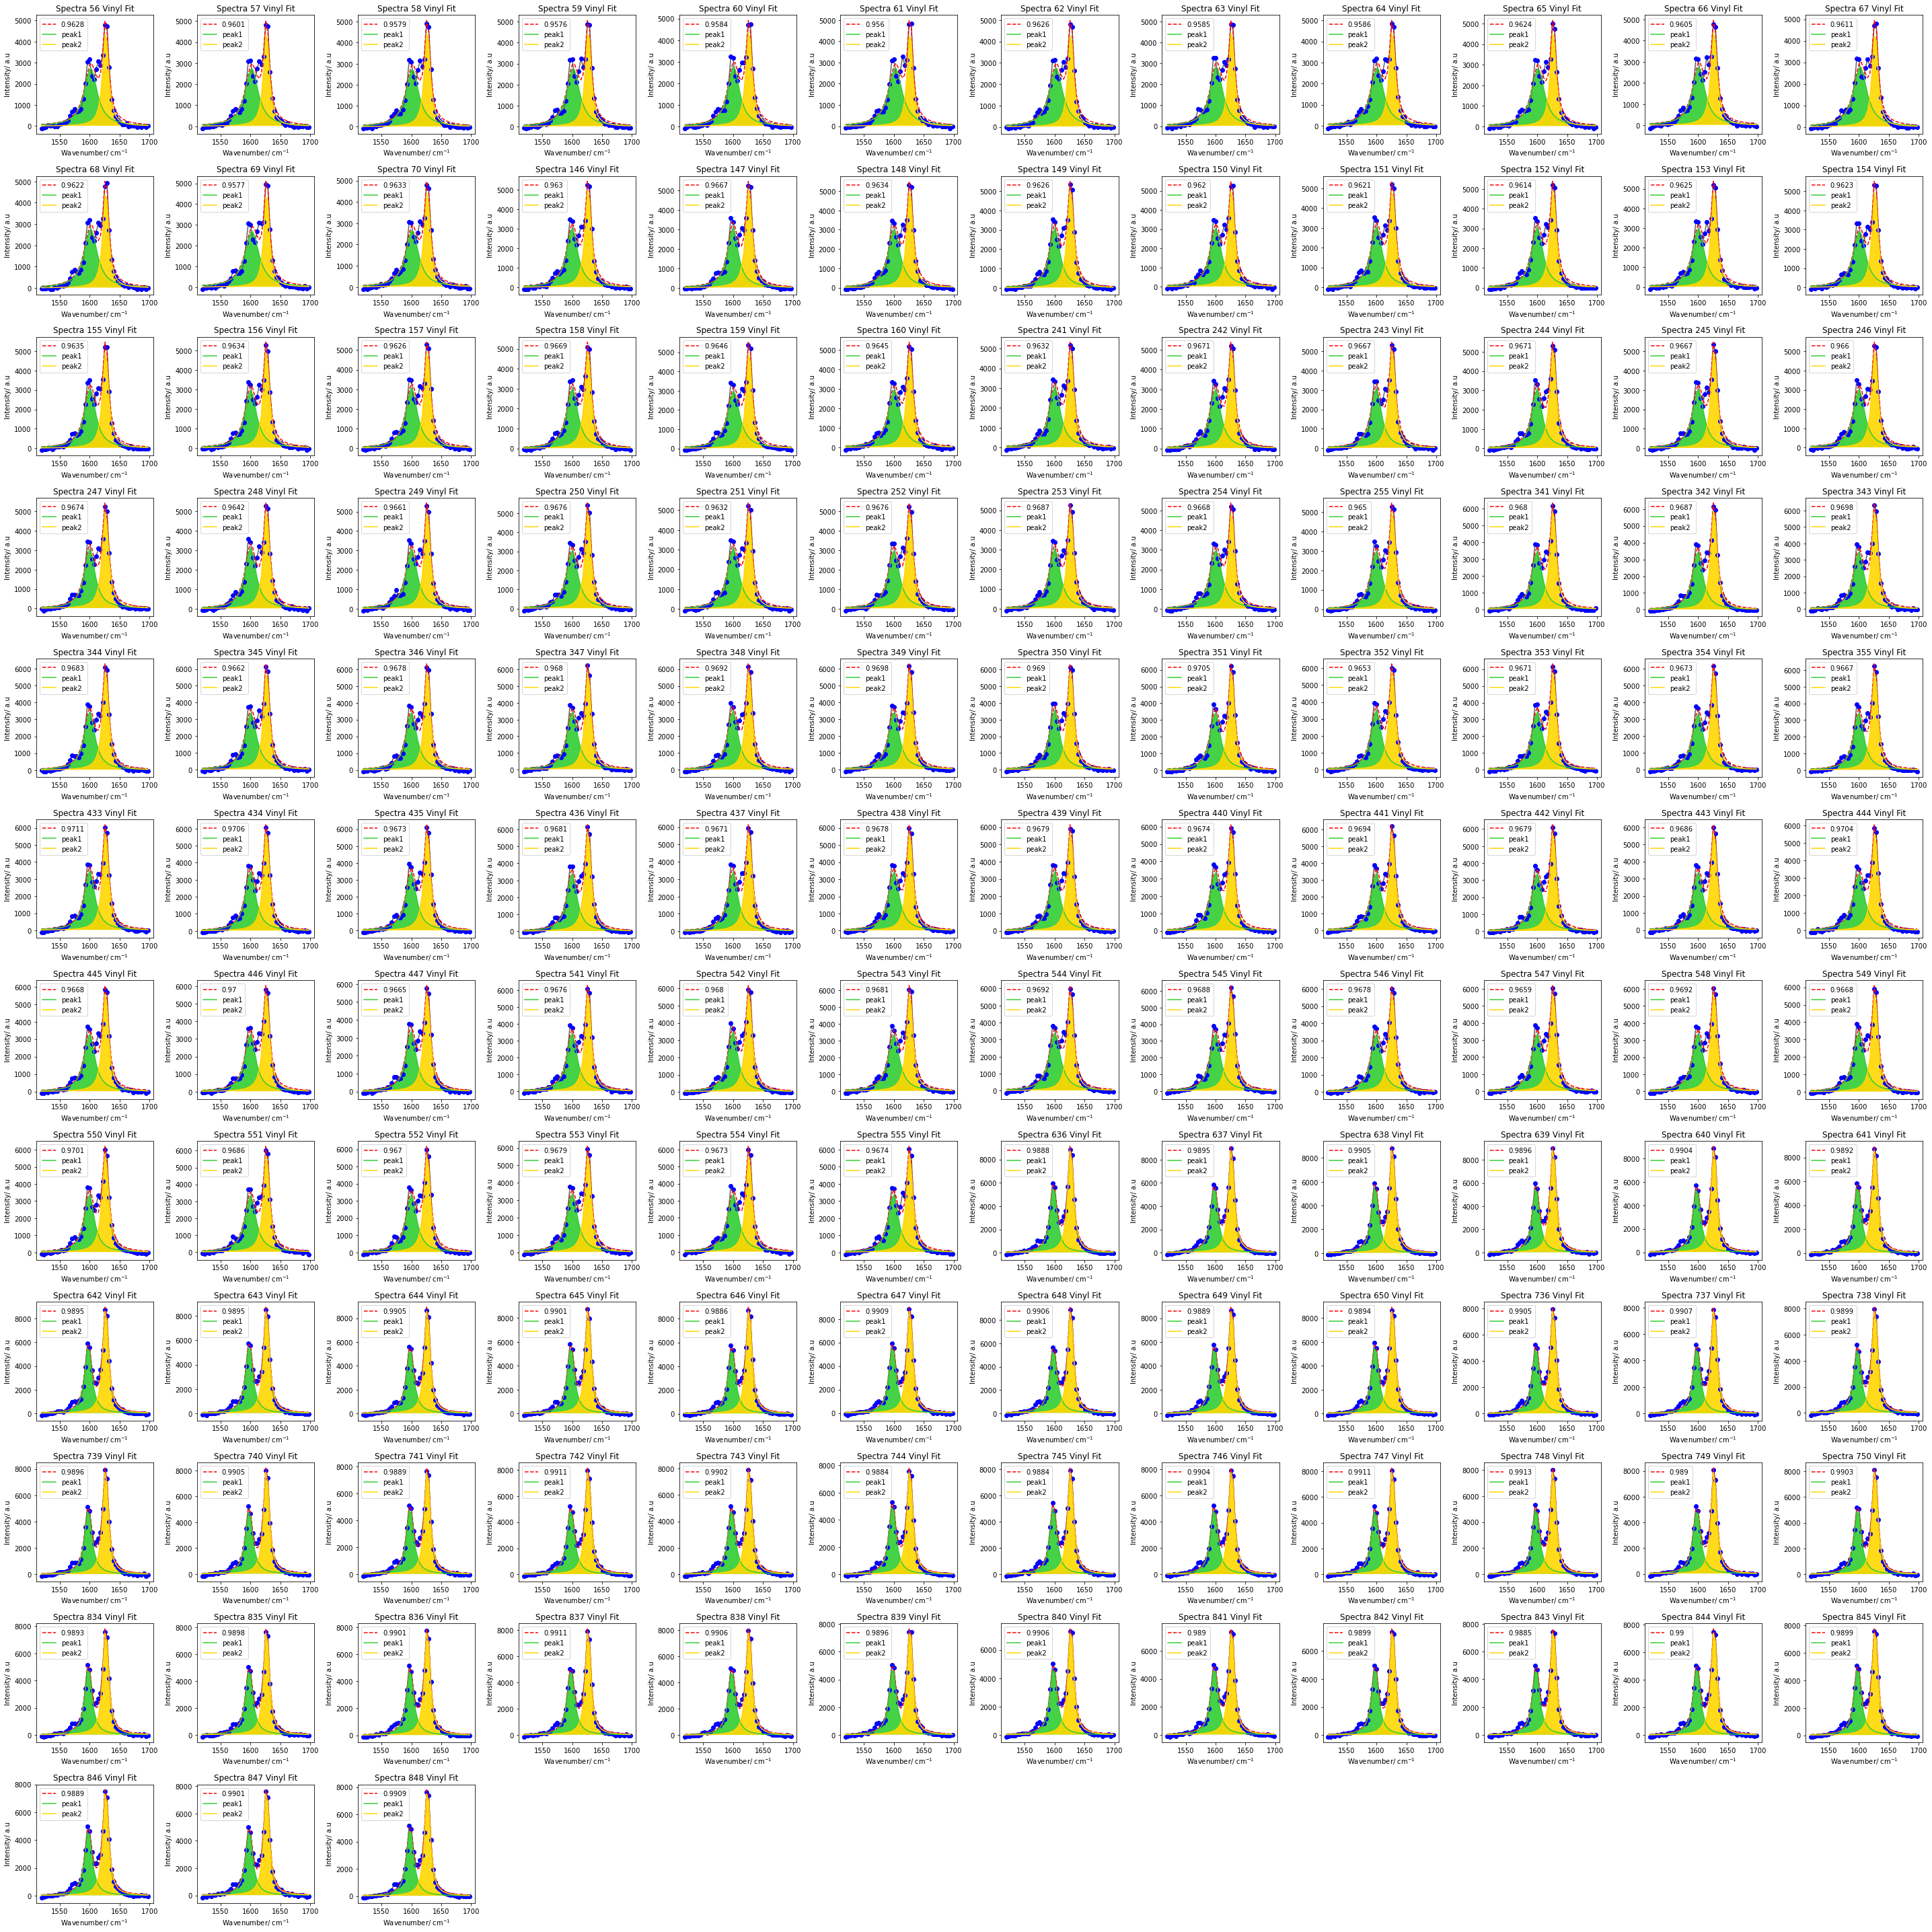

In [18]:
de = collections.deque([])
Area_1 = collections.deque([])
Area_2 = collections.deque([])

pbar = tqdm(total = len(df_vinyl), dynamic_ncols  = True, desc = 'Fitting curves')

plt.figure(figsize = (40,40))

pfit = Parameters()
pfit.add(name='ampL1', value = ampL1, min = 0)
pfit.add(name='ampL2', value = ampL2, min = 0)
pfit.add(name='cenL1', value = cenL1, max = 1605)
pfit.add(name='cenL2', value = cenL2, min = 1620, max = 1640)
pfit.add(name='widL1', value = widL1, min = 0)
pfit.add(name='widL2', value = widL2, min = 0)

for i,item in df_vinyl.iterrows():
    
    x = df_vinyl.columns # Wavenumbers
    
    y = item # Intensities
    
    xbl = []

    for items in y.index[:10].values.tolist():
        xbl.append(items)

    for items in y.index[40:].values.tolist():
        xbl.append(items)


    ybl = []

    for items in y.values[:10].tolist():
        ybl.append(items)

    for items in y.values[40:].tolist():
        ybl.append(items)
    
    blpars = np.polyfit(xbl, ybl, 1)
    blfit = np.poly1d(blpars)
    
    y -= blfit(x) # Corrected Intensities

    mini = Minimizer(residuals, pfit, fcn_args=(x, y))
    out = mini.leastsq()
    best_fit = y + out.residual
    
    fit_params = out.params.valuesdict()
    fit_params['R2'] = r2_score(y,best_fit)
    fit_params['FWHM_L1'] = 2*out.params.valuesdict()['widL1']
    fit_params['FWHM_L2'] = 2*out.params.valuesdict()['widL2']
    fit_params['Height_L1'] = 0.3183099*out.params.valuesdict()['ampL1']/max(2.220446049250313e-16, out.params.valuesdict()['widL1'])
    fit_params['Height_L2'] = 0.3183099*out.params.valuesdict()['ampL2']/max(2.220446049250313e-16, out.params.valuesdict()['widL2'])
    
    
    results = de.append(fit_params)
    
    peak1 = lorentzian(x,out.params.valuesdict()['ampL1'], out.params.valuesdict()['cenL1'], out.params.valuesdict()['widL1'])
    peak2 = lorentzian(x,out.params.valuesdict()['ampL2'], out.params.valuesdict()['cenL2'], out.params.valuesdict()['widL2'])
    
    plt.subplot(int(np.ceil(np.sqrt(df_vinyl.shape[0]))),int(np.ceil(np.sqrt(df_vinyl.shape[0]))),(1+i))
    # int() prior to np.ceil was added because subplots no longer accept any other data type except for int.
    plt.title('Spectra ' + str(df.loc[i, 'Original Index']) + ' Vinyl Fit')
    plt.xlabel('Wavenumber/ cm$^{-1}$')
    plt.ylabel('Intensity/ a.u')
    plt.plot(x, y, '#606060')
    plt.plot(x, y, 'bo')
    plt.plot(x, best_fit, 'r--', label = str(fit_params['R2'].round(decimals = 4)))
    plt.plot(x, peak1,'#32CD32', label = 'peak1')
    plt.fill_between(x, peak1.min(), peak1, facecolor = '#32CD32', alpha = 0.9)
    plt.plot(x, peak2,'#FFD700', label = 'peak2')
    plt.fill_between(x, peak2.min(), peak2, facecolor = '#FFD700', alpha = 0.9)
    plt.legend(loc='best')
   
    Area_1.append(integrate.simps(peak1, x)) 
    Area_2.append(integrate.simps(peak2, x))
    
    pbar.update(1)
    
pbar.close()
    
plt.tight_layout()
plt.show()

In [19]:
results = pd.DataFrame(de)
results.rename(columns={'R2':'R2_Vinyl'}, inplace=True)
results.describe()

ampL1          ampL2        cenL1        cenL2       widL1  \
count     135.000000     135.000000   135.000000   135.000000  135.000000   
mean   113134.679007  116423.737033  1599.422813  1626.628553    9.926198   
std      6030.429183   22890.284185     1.297221     0.157862    2.092331   
min     98608.471278   77873.126712  1597.586174  1626.269357    6.931909   
25%    109292.963895   97419.099403  1597.908305  1626.520298    7.273592   
50%    112225.023072  112150.251824  1599.742294  1626.626232   10.577700   
75%    115524.999622  138201.542904  1600.109764  1626.712072   11.305125   
max    128639.586245  162230.063101  1602.492299  1627.038664   14.069268   

            widL2    R2_Vinyl     FWHM_L1     FWHM_L2    Height_L1  \
count  135.000000  135.000000  135.000000  135.000000   135.000000   
mean     5.816703    0.973759   19.852395   11.633406  3824.699444   
std      0.291249    0.011797    4.184663    0.582498   981.495172   
min      5.309093    0.955977   13.863819   10.618187  2673.249489   
25%      5.545999    0.965942   14.547185   11.091998  3046.980711   
50%      5.891851    0.967977   21.155400   11.783702  3387.509259   
75%      6.048326    0.989224   22.610250   12.096652  4918.516201   
max      6.439467    0.991270   28.138537   12.878935  5735.734764   

         Height_L2  
count   135.000000  
mean   6420.832442  
std    1491.364525  
min    4537.410615  
25%    5159.305223  
50%    5933.352184  
75%    8001.258532  
max    9240.319494

For 2 Lorentzians peak fits within the region of interest:

In [20]:
Area_2 = pd.Series(Area_2)
labels = df.iloc[:, 0:2]
df_area = pd.concat([labels, Area_2, results['R2_Vinyl']], axis=1)
df_area.rename(columns={0: 'Vinyl Peak Area'}, inplace=True)
df_area

Original Index Condition  Vinyl Peak Area  R2_Vinyl
0                56     C1_R1     80163.474653  0.962819
1                57     C1_R1     78528.492160  0.960140
2                58     C1_R1     80301.698331  0.957938
3                59     C1_R1     81072.241319  0.957603
4                60     C1_R1     84075.506967  0.958369
..              ...       ...              ...       ...
130             844    C10_R3    132339.320365  0.989974
131             845    C10_R3    132088.439258  0.989894
132             846    C10_R3    130502.006021  0.988926
133             847    C10_R3    130815.425898  0.990113
134             848    C10_R3    133112.820770  0.990896

[135 rows x 4 columns]

# Fitting and Plotting (p-xylene Region)

In [21]:
df_pxyl = df.iloc[:, 151:180].copy()
df_pxyl.columns = df_pxyl.columns.astype('float')
df_pxyl

742.419650  746.548026  750.676492  754.803068  758.925774  763.046594  \
0         532.0       445.0       433.0       307.0       446.0       569.0   
1         495.0       432.0       404.0       286.0       434.0       546.0   
2         548.0       453.0       369.0       363.0       418.0       553.0   
3         506.0       498.0       374.0       342.0       443.0       582.0   
4         527.0       437.0       407.0       308.0       408.0       567.0   
..          ...         ...         ...         ...         ...         ...   
130       492.0       415.0       422.0       391.0       434.0       694.0   
131       489.0       425.0       421.0       416.0       462.0       723.0   
132       500.0       476.0       468.0       388.0       451.0       669.0   
133       532.0       414.0       449.0       449.0       543.0       724.0   
134       479.0       433.0       385.0       315.0       456.0       731.0   

     767.165528  771.280601  775.393794  779.505106  ...  820.487608  \
0         922.0      1253.0      1011.0       662.0  ...      5096.0   
1         912.0      1252.0      1061.0       633.0  ...      4915.0   
2         957.0      1273.0      1006.0       720.0  ...      4908.0   
3         852.0      1137.0      1039.0       644.0  ...      4929.0   
4         984.0      1172.0       998.0       615.0  ...      4907.0   
..          ...         ...         ...         ...  ...         ...   
130      1332.0      1769.0      1467.0       813.0  ...      2331.0   
131      1304.0      1807.0      1488.0       824.0  ...      2265.0   
132      1319.0      1861.0      1437.0       853.0  ...      2277.0   
133      1302.0      1754.0      1424.0       839.0  ...      2206.0   
134      1246.0      1865.0      1449.0       913.0  ...      2360.0   

     824.570481  828.653461  832.734583  836.813849  840.889298  844.962895  \
0        7708.0      6862.0      3514.0      1369.0       737.0       403.0   
1        7603.0      6944.0      3361.0      1356.0       701.0       493.0   
2        7731.0      6760.0      3458.0      1370.0       736.0       502.0   
3        7581.0      6861.0      3410.0      1339.0       650.0       433.0   
4        7657.0      6725.0      3511.0      1408.0       695.0       521.0   
..          ...         ...         ...         ...         ...         ...   
130      3295.0      3024.0      1572.0       756.0       466.0       347.0   
131      3392.0      2858.0      1629.0       752.0       468.0       290.0   
132      3467.0      2993.0      1548.0       768.0       451.0       334.0   
133      3310.0      2865.0      1573.0       744.0       438.0       386.0   
134      3294.0      2958.0      1570.0       790.0       505.0       398.0   

     849.032682  853.100620  857.166712  
0         318.0       290.0       220.0  
1         410.0       306.0       278.0  
2         344.0       285.0       251.0  
3         346.0       287.0       255.0  
4         368.0       302.0       277.0  
..          ...         ...         ...  
130       287.0       256.0       231.0  
131       293.0       251.0       250.0  
132       359.0       301.0       277.0  
133       257.0       244.0       243.0  
134       308.0       296.0       220.0  

[135 rows x 29 columns]

In [22]:
def residuals(pars,x,y):
    
    model =  (lorentzian(x, pars['ampL1'], pars['cenL1'], pars['widL1']) +
              lorentzian(x, pars['ampL2'], pars['cenL2'], pars['widL2']) +
              split_lorentzian(x, pars['ampL3'], pars['cenL3'], pars['widL3'],pars['widL4']))
    
    return model - y

In [23]:
ampL1 = 20000
cenL1 = 772 
widL1 = 3

ampL2 = 25000 
cenL2 = 808
widL2 = 5

ampL3 = 100000
cenL3 = 826
widL3 = 6
widL4 = 4

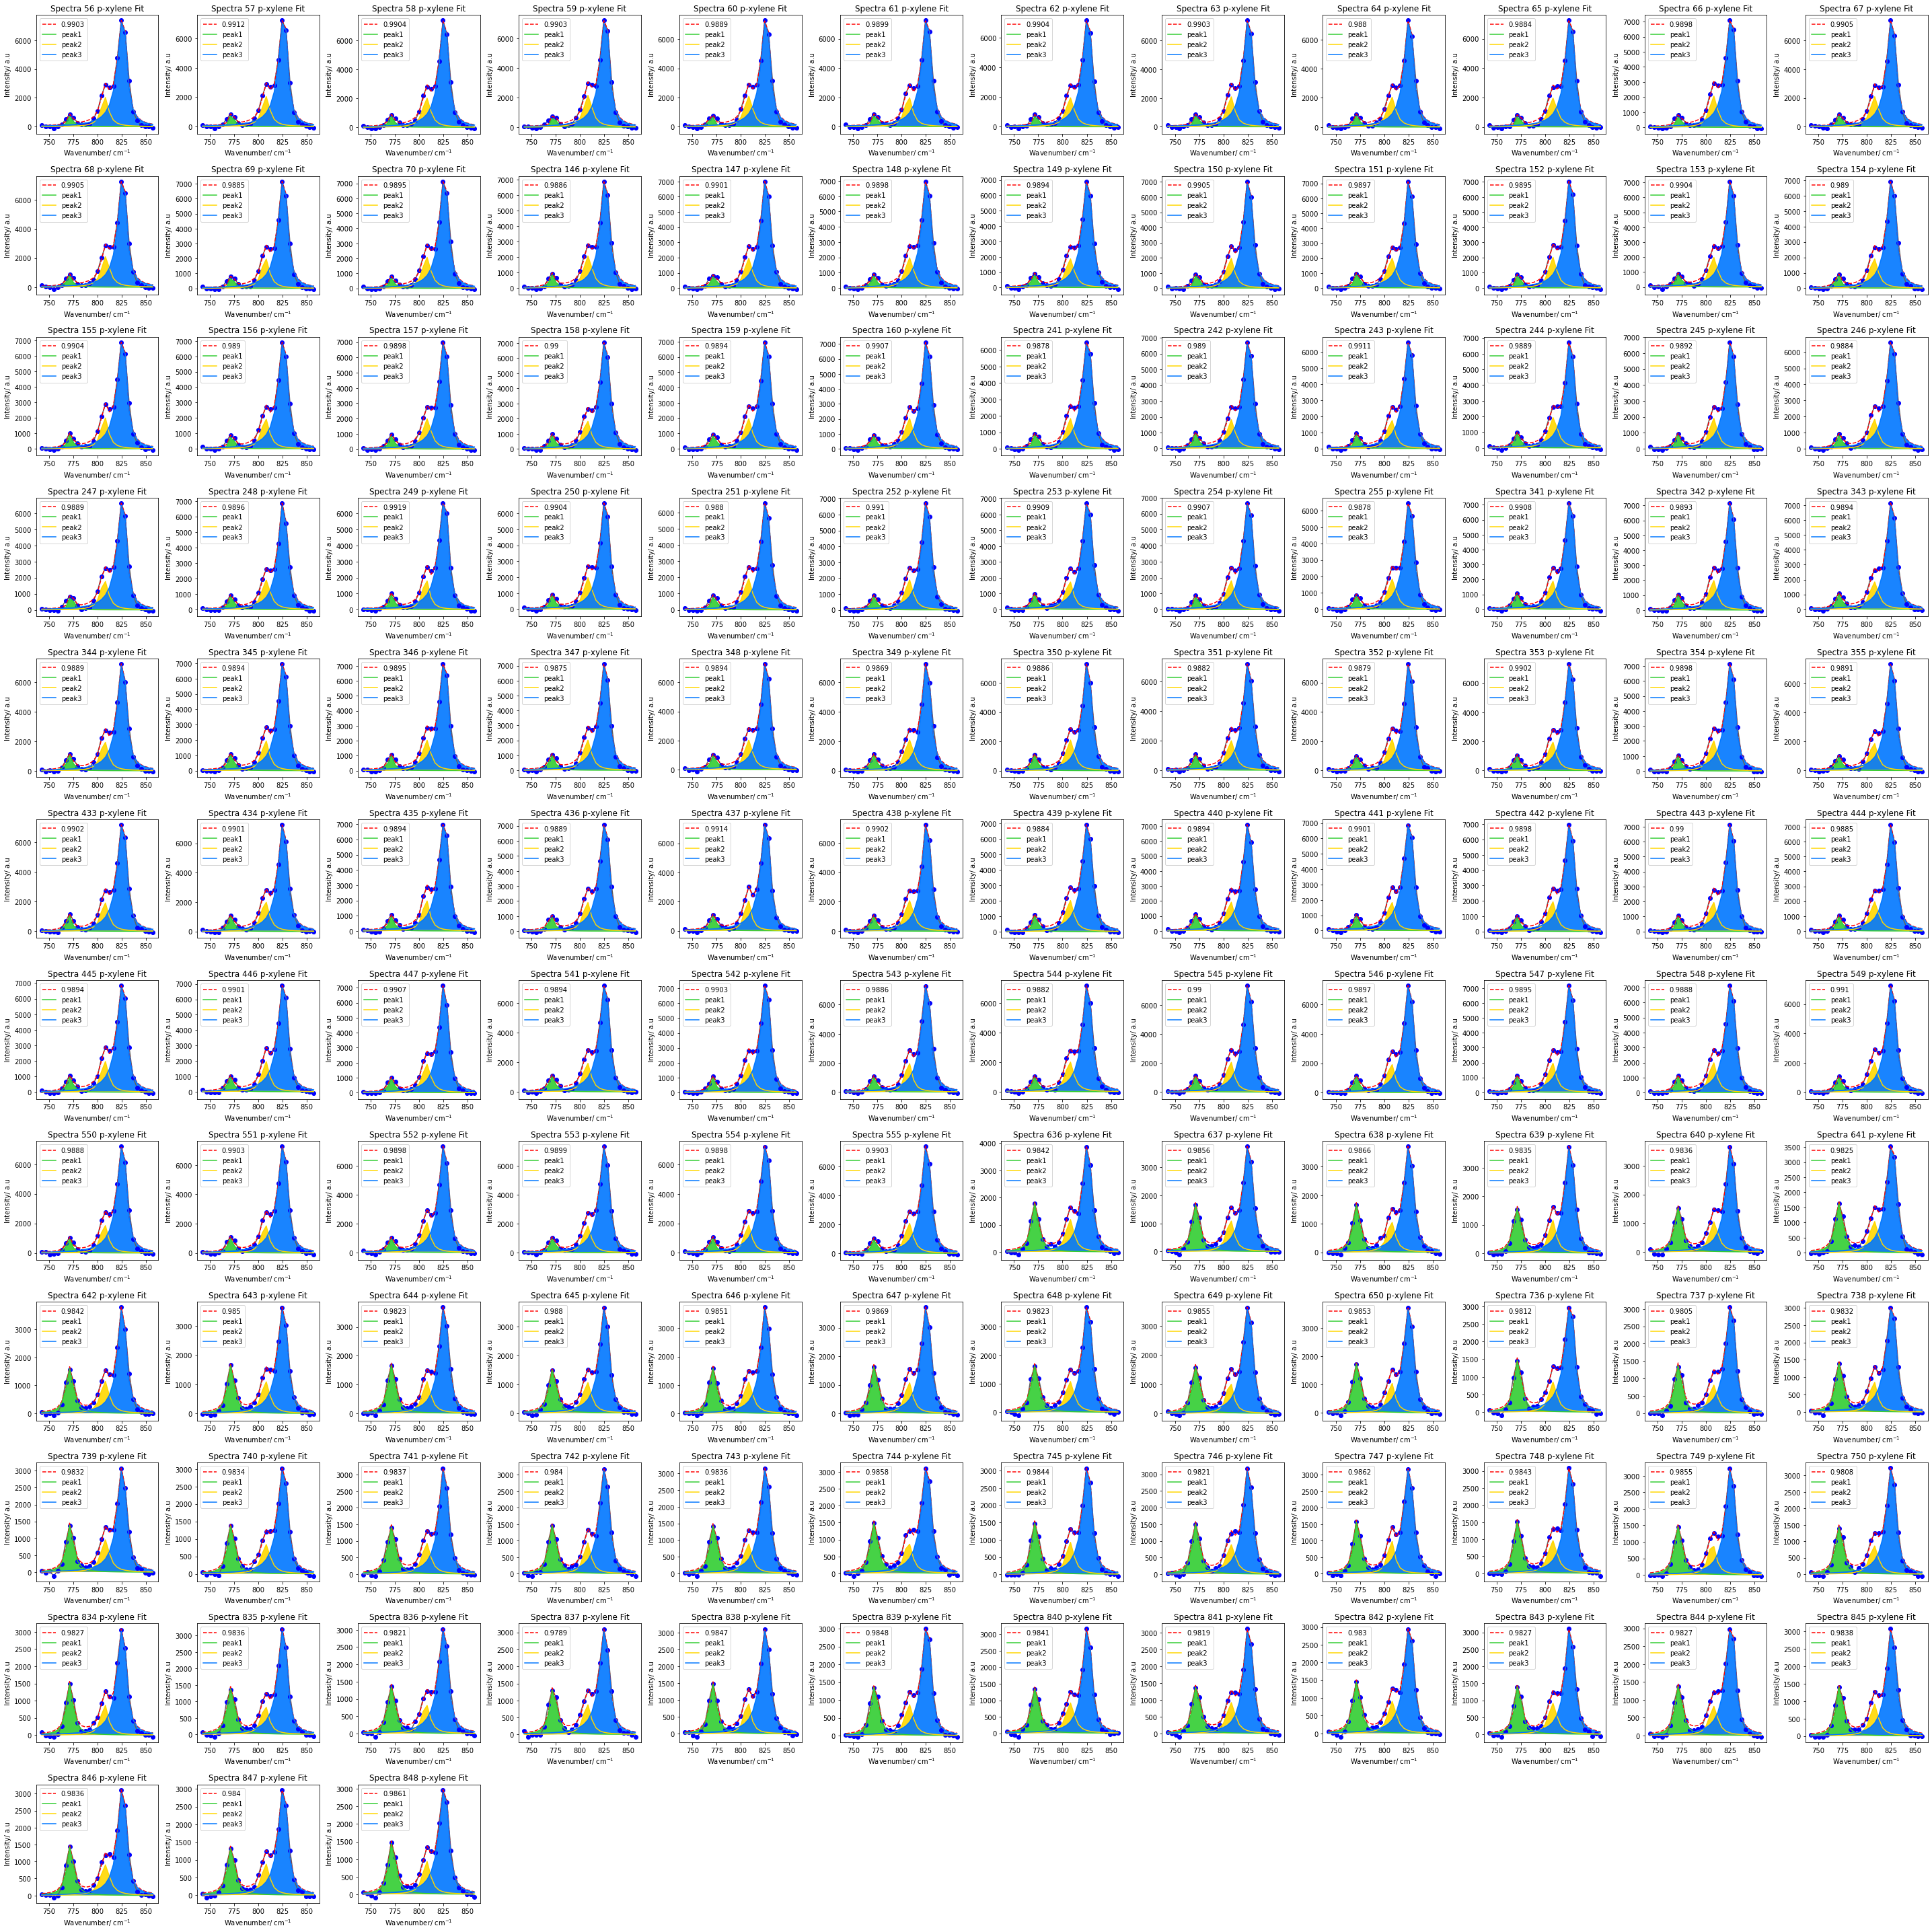

In [24]:
de = collections.deque([])
Area_1 = collections.deque([])
Area_2 = collections.deque([])
Area_3 = collections.deque([])

pbar = tqdm(total = len(df_pxyl), dynamic_ncols  = True, desc = 'Fitting curves')

plt.figure(figsize = (40,40))

pfit = Parameters()
pfit.add(name='ampL1', value = ampL1, min = 0)
pfit.add(name='ampL2', value = ampL2, min = 0)
pfit.add(name='ampL3', value = ampL3, min = 0)
pfit.add(name='cenL1', value = cenL1, min = 770, max = 780)
pfit.add(name='cenL2', value = cenL2, min = 805, max = 815)
pfit.add(name='cenL3', value = cenL3, min = 820, max = 830)
pfit.add(name='widL1', value = widL1, min = 0)
pfit.add(name='widL2', value = widL2, min = 0)
pfit.add(name='widL3', value = widL3, min = 0)
pfit.add(name='widL4', value = widL4, min = 0)

for i,item in df_pxyl.iterrows():
    
    x = df_pxyl.columns # Wavenumbers
    
    y = item # Intensities
    
    xbl = []

    for items in y.index[:5].values.tolist():
        xbl.append(items)

    for items in y.index[25:].values.tolist():
        xbl.append(items)


    ybl = []

    for items in y.values[:5].tolist():
        ybl.append(items)

    for items in y.values[25:].tolist():
        ybl.append(items)
    
    blpars = np.polyfit(xbl, ybl, 1)
    blfit = np.poly1d(blpars)
    
    y -= blfit(x) # Corrected Intensities

    mini = Minimizer(residuals, pfit, fcn_args=(x, y))
    out = mini.leastsq()
    best_fit = y + out.residual
    
    fit_params = out.params.valuesdict()
    fit_params['R2'] = r2_score(y,best_fit)
    fit_params['FWHM_L1'] = 2*out.params.valuesdict()['widL1']
    fit_params['FWHM_L2'] = 2*out.params.valuesdict()['widL2']
    fit_params['FWHM_L3'] = out.params.valuesdict()['widL3'] + out.params.valuesdict()['widL4']
    fit_params['Height_L1'] = 0.318309886*out.params.valuesdict()['ampL1']/max(2.220446049250313e-16, out.params.valuesdict()['widL1'])
    fit_params['Height_L2'] = 0.318309886*out.params.valuesdict()['ampL2']/max(2.220446049250313e-16, out.params.valuesdict()['widL2'])
    fit_params['Height_L3'] = 0.318309886*out.params.valuesdict()['ampL3']/max(2.220446049250313e-16, out.params.valuesdict()['widL3']+out.params.valuesdict()['widL4'])
    
    results = de.append(fit_params)
    
    peak1 = lorentzian(x,out.params.valuesdict()['ampL1'], out.params.valuesdict()['cenL1'], out.params.valuesdict()['widL1'])
    peak2 = lorentzian(x,out.params.valuesdict()['ampL2'], out.params.valuesdict()['cenL2'], out.params.valuesdict()['widL2'])
    peak3 = split_lorentzian(x,out.params.valuesdict()['ampL3'], out.params.valuesdict()['cenL3'], out.params.valuesdict()['widL3'], out.params.valuesdict()['widL4'])
    
    plt.subplot(int(np.ceil(np.sqrt(df_pxyl.shape[0]))),int(np.ceil(np.sqrt(df_pxyl.shape[0]))),(1+i))
    # int() prior to np.ceil was added because subplots no longer accept any other data type except for int.
    plt.title('Spectra ' + str(df.loc[i, 'Original Index']) + ' p-xylene Fit')
    plt.xlabel('Wavenumber/ cm$^{-1}$')
    plt.ylabel('Intensity/ a.u')
    plt.plot(x, y, '#606060')
    plt.plot(x, y, 'bo')
    plt.plot(x, best_fit, 'r--', label = str(fit_params['R2'].round(decimals = 4)))
    plt.plot(x, peak1,'#32CD32', label = 'peak1')
    plt.fill_between(x, peak1.min(), peak1, facecolor = '#32CD32', alpha = 0.9)
    plt.plot(x, peak2,'#FFD700', label = 'peak2')
    plt.fill_between(x, peak2.min(), peak2, facecolor = '#FFD700', alpha = 0.9)
    plt.plot(x, peak3,'#0077FF', label = 'peak3')
    plt.fill_between(x, peak3.min(), peak3, facecolor = '#0077FF', alpha = 0.9)
    plt.legend(loc='best')
   
    Area_1.append(integrate.simps(peak1, x)) 
    Area_2.append(integrate.simps(peak2, x))
    Area_3.append(integrate.simps(peak3, x))
    
    pbar.update(1)
    
plt.tight_layout()
plt.show()

In [25]:
results = pd.DataFrame(de)
results.rename(columns={'R2':'R2_pxyl'}, inplace=True)
results.describe()

ampL1         ampL2          ampL3       cenL1       cenL2  \
count    135.000000    135.000000     135.000000  135.000000  135.000000   
mean   13307.163791  25624.857533  107211.198819  771.809863  807.539582   
std     5573.903297   7611.448498   33608.543365    0.534410    0.346015   
min     6499.436557  12389.321548   53577.442830  770.000000  806.513276   
25%     8886.635041  16941.918745   65704.333157  771.502635  807.289302   
50%    10736.771077  29338.095115  127416.545267  771.775339  807.550637   
75%    19632.207194  31497.390402  132907.199399  772.040679  807.776283   
max    24133.964960  37025.779178  139946.411295  773.178751  808.471729   

            cenL3       widL1       widL2       widL3       widL4     R2_pxyl  \
count  135.000000  135.000000  135.000000  135.000000  135.000000  135.000000   
mean   826.591442    3.563658    4.929486    6.880152    4.186643    0.987657   
std      0.147855    0.776677    0.331949    0.285249    0.113883    0.003019   
min    826.234880    0.703440    3.988605    6.200531    3.899825    0.978941   
25%    826.483899    3.233449    4.697196    6.704416    4.102042    0.985068   
50%    826.603681    3.515007    4.918957    6.873876    4.186418    0.988943   
75%    826.704133    4.313020    5.172656    7.080647    4.255366    0.990009   
max    826.882799    4.719065    5.655214    7.664503    4.515397    0.991876   

          FWHM_L1     FWHM_L2     FWHM_L3    Height_L1    Height_L2  \
count  135.000000  135.000000  135.000000   135.000000   135.000000   
mean     7.127317    9.858972   11.066795  1187.693769  1660.197186   
std      1.553355    0.663897    0.305362   472.127075   493.213421   
min      1.406880    7.977211   10.192579   691.599499   814.160644   
25%      6.466899    9.394393   10.868090   933.129304  1086.083212   
50%      7.030015    9.837914   11.089589  1026.296452  1955.525460   
75%      8.626041   10.345313   11.260382  1432.280482  2033.286537   
max      9.438131   11.310427   11.847460  4769.064863  2173.346999   

         Height_L3  
count   135.000000  
mean   3086.919917  
std     971.513967  
min    1564.448679  
25%    1924.360032  
50%    3685.176012  
75%    3823.730787  
max    3960.701053

In [26]:
df_area = pd.concat([df_area, pd.Series(Area_3), results['R2_pxyl']], axis=1)
df_area.rename(columns={0: 'pxyl Peak Area'}, inplace=True)
df_area

Original Index Condition  Vinyl Peak Area  R2_Vinyl  pxyl Peak Area  \
0                56     C1_R1     80163.474653  0.962819   130942.488215   
1                57     C1_R1     78528.492160  0.960140   126215.720129   
2                58     C1_R1     80301.698331  0.957938   126332.061675   
3                59     C1_R1     81072.241319  0.957603   124730.424937   
4                60     C1_R1     84075.506967  0.958369   124978.535536   
..              ...       ...              ...       ...             ...   
130             844    C10_R3    132339.320365  0.989974    54008.808900   
131             845    C10_R3    132088.439258  0.989894    51823.445451   
132             846    C10_R3    130502.006021  0.988926    50223.257223   
133             847    C10_R3    130815.425898  0.990113    51059.617182   
134             848    C10_R3    133112.820770  0.990896    53332.335773   

      R2_pxyl  
0    0.990330  
1    0.991152  
2    0.990366  
3    0.990300  
4    0.988908  
..        ...  
130  0.982696  
131  0.983822  
132  0.983591  
133  0.983979  
134  0.986071  

[135 rows x 6 columns]

In [27]:
# Keep only columns with R2 values above a threshold.
df_area = df_area[(df_area['R2_Vinyl'] > 0.95) & (df_area['R2_pxyl'] > 0.95)]

# Normalization
df_area['Vinyl Divide pxyl'] =  df_area['Vinyl Peak Area'] / df_area['pxyl Peak Area']

df_area

Original Index Condition  Vinyl Peak Area  R2_Vinyl  pxyl Peak Area  \
0                56     C1_R1     80163.474653  0.962819   130942.488215   
1                57     C1_R1     78528.492160  0.960140   126215.720129   
2                58     C1_R1     80301.698331  0.957938   126332.061675   
3                59     C1_R1     81072.241319  0.957603   124730.424937   
4                60     C1_R1     84075.506967  0.958369   124978.535536   
..              ...       ...              ...       ...             ...   
130             844    C10_R3    132339.320365  0.989974    54008.808900   
131             845    C10_R3    132088.439258  0.989894    51823.445451   
132             846    C10_R3    130502.006021  0.988926    50223.257223   
133             847    C10_R3    130815.425898  0.990113    51059.617182   
134             848    C10_R3    133112.820770  0.990896    53332.335773   

      R2_pxyl  Vinyl Divide pxyl  
0    0.990330           0.612204  
1    0.991152           0.622177  
2    0.990366           0.635640  
3    0.990300           0.649980  
4    0.988908           0.672720  
..        ...                ...  
130  0.982696           2.450328  
131  0.983822           2.548816  
132  0.983591           2.598438  
133  0.983979           2.562013  
134  0.986071           2.495912  

[135 rows x 7 columns]

In [28]:
# View the summary statistics
df_area_stats = df_area[['Condition', 'Vinyl Divide pxyl']].groupby('Condition').describe()
df_area_stats

Vinyl Divide pxyl                                                    \
                      count      mean       std       min       25%       50%   
Condition                                                                       
C10_R1                 15.0  2.402749  0.061829  2.314593  2.361618  2.394781   
C10_R2                 15.0  2.504733  0.070596  2.406594  2.442834  2.491713   
C10_R3                 15.0  2.506345  0.055400  2.398957  2.475260  2.495912   
C19_R1                 15.0  0.877109  0.028323  0.820781  0.853737  0.877214   
C19_R2                 15.0  0.865360  0.019387  0.835632  0.858004  0.863886   
C19_R3                 15.0  0.848077  0.026492  0.800488  0.834986  0.848994   
C1_R1                  15.0  0.634889  0.026287  0.583539  0.617935  0.635640   
C1_R2                  15.0  0.764616  0.026653  0.722353  0.749214  0.757796   
C1_R3                  15.0  0.802219  0.033983  0.741428  0.783537  0.816164   

                               
                75%       max  
Condition                      
C10_R1     2.422417  2.543115  
C10_R2     2.558990  2.641282  
C10_R3     2.551924  2.598438  
C19_R1     0.899639  0.913919  
C19_R2     0.872166  0.914728  
C19_R3     0.865514  0.890558  
C1_R1      0.649732  0.676543  
C1_R2      0.770777  0.817191  
C1_R3      0.818638  0.873697

In [29]:
mean = df_area_stats['Vinyl Divide pxyl', 'mean'].values
std = df_area_stats['Vinyl Divide pxyl', 'std'].values
condition = ['10_Repeat', '10_Repeat_2', '10_Repeat_3', '19_Repeat', '19_Repeat_1' , '19_Repeat_2',
             '1_Repeat', '1_Repeat_2', '1_Repeat_3']

In [30]:
df_ratio = pd.DataFrame({'Condition':condition, 'Mean Ratio':mean, 'Standard Deviation': std})
df_ratio = df_ratio.reindex([6, 7, 8, 3, 4, 5, 0, 1, 2])
df_ratio = df_ratio.reset_index(drop=True)
df_ratio

Condition  Mean Ratio  Standard Deviation
0     1_Repeat    0.634889            0.026287
1   1_Repeat_2    0.764616            0.026653
2   1_Repeat_3    0.802219            0.033983
3    19_Repeat    0.877109            0.028323
4  19_Repeat_1    0.865360            0.019387
5  19_Repeat_2    0.848077            0.026492
6    10_Repeat    2.402749            0.061829
7  10_Repeat_2    2.504733            0.070596
8  10_Repeat_3    2.506345            0.055400

In [31]:
df_ratio.to_csv(r'C:\Users\Tan Jin Da\Desktop\High Throughput Experiments Data\210224 High Throughput Experiment Conditions 1, 19 and 10 Repeat\Raman\df_t90_ratio_repeat.csv')